In [1]:
import torch
import torchio as tio
from torch.utils.data import DataLoader

In [2]:
path_to_data = '/home/msst/Documents/medtech/brain_seg_dataset/'
name1 = 'CT_S5020_uint16/'
name2 = 'P12_CTA(no_brain)/'

In [3]:
path1 = path_to_data+name1
subject1_dict = {
    'head': tio.ScalarImage(path1 + 'head.nii.gz'),
    'vessels': tio.LabelMap(path1 + 'vessels.nii.gz'),
    'brain': tio.LabelMap(path1 + 'brain.nii.gz'),
}

subject1 = tio.Subject(subject1_dict)

In [4]:
subject1

Subject(Keys: ('head', 'vessels', 'brain'); images: 3)

In [4]:
subject1.head.affine

array([[0.42578125, 0.        , 0.        , 0.        ],
       [0.        , 0.42578125, 0.        , 0.        ],
       [0.        , 0.        , 0.44999999, 0.        ],
       [0.        , 0.        , 0.        , 1.        ]])

In [5]:
path2 = path_to_data+name2
subject2_dict = {
    'head': tio.ScalarImage(path1 + 'head.nii.gz'),
    'vessels': tio.LabelMap(path1 + 'vessels.nii.gz'),
    'brain': tio.LabelMap(path1 + 'brain.nii.gz'),
}

subject2 = tio.Subject(subject2_dict)

In [6]:
subjects_list = [subject1, subject2]
transforms = [
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.RandomAffine(),
]
transform = tio.Compose(transforms)
subjects_dataset = tio.SubjectsDataset(subjects_list, transform=transform)

In [8]:
#probability_map = np.zeros 

In [9]:
patch_size = 96

queue_length = 300

samples_per_volume = 8

sampler = tio.data.UniformSampler(patch_size)

patches_queue = tio.Queue(
    subjects_dataset,
    queue_length,
    samples_per_volume,
    sampler,
    num_workers=6,
)

patches_loader = DataLoader(
    patches_queue,
    batch_size=4,
    num_workers=0,  # this must be 0
)

In [14]:
num_epochs = 10
model = torch.nn.Identity()
for epoch_index in range(num_epochs):
    for patches_batch in patches_loader:
        print(patches_batch[tio.LOCATION])
        inputs = patches_batch['head']['data']  
        targets = patches_batch['vessels']['data'] 
        logits = model(inputs)
        print(inputs.shape, targets.shape)
        print(inputs.mean(), targets.mean())
    break

tensor([[159,  98,  15, 255, 194, 111],
        [144,  22, 239, 240, 118, 335],
        [ 72, 359, 144, 168, 455, 240],
        [ 62, 322, 251, 158, 418, 347]])
torch.Size([4, 1, 96, 96, 96]) torch.Size([4, 1, 96, 96, 96])
tensor(0.0957) tensor(0.0055)
tensor([[107, 303, 139, 203, 399, 235],
        [350, 393,  24, 446, 489, 120],
        [359, 322, 124, 455, 418, 220],
        [162, 156, 172, 258, 252, 268]])
torch.Size([4, 1, 96, 96, 96]) torch.Size([4, 1, 96, 96, 96])
tensor(0.2011) tensor(0.0032)
tensor([[145, 328,  77, 241, 424, 173],
        [284,  56, 182, 380, 152, 278],
        [167, 271, 131, 263, 367, 227],
        [ 67, 237, 204, 163, 333, 300]])
torch.Size([4, 1, 96, 96, 96]) torch.Size([4, 1, 96, 96, 96])
tensor(0.2596) tensor(0.0090)
tensor([[151,  74, 106, 247, 170, 202],
        [398, 184, 157, 494, 280, 253],
        [138, 267,  81, 234, 363, 177],
        [387, 161, 252, 483, 257, 348]])
torch.Size([4, 1, 96, 96, 96]) torch.Size([4, 1, 96, 96, 96])
tensor(0.2475) ten

In [7]:
import torch.nn as nn
from ml.models.unet_deepsup import U_Net_DeepSup
from scripts.load_and_save import load_nii_vol, save_vol_as_nii

In [32]:
path_to_test_data = '/home/msst/Documents/medtech/brain_seg_dataset_test/'

name1 = 'P28_CTA_(0.42, 0.42, 0.3)(no_seg)/'
name2 = 'P35_CTA 0.625mm(no_seg)/'
name3 = 'P70_CTA 0.625mm(no_seg)/'

subjects_list = []
def add_subject(path):
    subject_dict = {
        'head': tio.ScalarImage(path + 'head.nii.gz'),
        'vessels': tio.LabelMap(path + 'vessels.nii.gz'),
        'brain': tio.LabelMap(path + 'brain.nii.gz'),
    }

    subject = tio.Subject(subject_dict)
    subjects_list.append(subject)
    
add_subject(path_to_test_data + name1)
add_subject(path_to_test_data + name2)
add_subject(path_to_test_data + name3)

transforms = [
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.RandomAffine(),
]
test_dataset = tio.SubjectsDataset(subjects_list, transform=transform)

In [33]:
class swish(nn.Module):
    def forward(self, input_tensor):
        return input_tensor * torch.sigmoid(input_tensor)

model = U_Net_DeepSup(channel_coef=16, act_fn=swish())
model_name = "UnetMSS16_logTversky_100"
model.load_state_dict(torch.load("/home/msst/repo/MSRepo/VesselSegmentation/saved_models/" + model_name)["model_state_dict"])

<All keys matched successfully>

In [34]:
PATCH_SIZE = (128, 128, 96)
OVERLAP_SIZE = (32, 32, 24)
BATCH_SIZE = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
out = []
model.to(device)
model.eval()
for subject in test_dataset:
    affine = subject.head.affine
    grid_sampler = tio.GridSampler(subject, patch_size=PATCH_SIZE, patch_overlap=OVERLAP_SIZE)
    print(len(grid_sampler))
    grid_aggregator = tio.data.GridAggregator(sampler=grid_sampler, overlap_mode='hann')
    patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=BATCH_SIZE)
    for patches_batch in patch_loader:
        patch_locations = patches_batch[tio.LOCATION]
        head_patches = patches_batch['head']['data'].to(device)
        with torch.no_grad():
            grid_aggregator.add_batch(model(head_patches)[0].cpu(), patch_locations)
    out.append((grid_aggregator.get_output_tensor(), affine))

175
125
100


In [36]:
data_dir = "seg_data/"
for idx, (seg_vol, affine) in enumerate(out):  
    print(seg_vol.shape)
    print(seg_vol.sum())
    path_to_save_vessels = data_dir + f'{idx+1}.nii.gz'
    save_vol_as_nii(seg_vol[0], affine, path_to_save_vessels)

torch.Size([1, 512, 512, 512])
tensor(1682519.)
torch.Size([1, 512, 512, 320])
tensor(315363.4375)
torch.Size([1, 512, 512, 256])
tensor(404754.5625)


In [78]:
import matplotlib.pyplot as plt
import torch
import torchio as tio
import numpy as np

In [91]:
p = "/home/msst/Documents/medtech/HeadData/test/new_CTA"
subject_dict = {'head': tio.ScalarImage(p + '/head.nii.gz'),
                'vessels': tio.LabelMap(p + '/vessels.nii.gz'),
                "sample_name" : "new_CTA"}
                #'brain': tio.LabelMap(p + '/brain.nii.gz')}
subject = tio.Subject(subject_dict)

In [141]:
def add_prob_map(subject, focus=1.5):
    print(subject.shape)
    _, h, w, d = subject.shape
    x0 = h//2
    y0 = w//2
    prob_slice = np.ones((h,w))
    
    for x in range(prob_slice.shape[0]):
        for y in range(prob_slice.shape[1]):
            prob_slice[x, y] = ((focus-((x/x0-1)**2 + (y/y0-1)**2)**0.5))

    prob_slice = prob_slice.clip(0, 1)
    prob_vol = np.stack(d*[prob_slice,], axis=2)
    print(prob_vol.shape)
    
    prob_Image = tio.Image(tensor=torch.tensor(prob_vol).unsqueeze(0), type=tio.SAMPLING_MAP, affine=subject.head.affine)
    subject.add_image(prob_Image, "prob_map")
    return(subject)


def print_img(vol, axis, title= 'title', show_slice=None, cmap='hot'):
    global SHOW_SLICE
    axis.set_title(title)
    if slice is None:
        im = axis.imshow(vol[:, :, SHOW_SLICE], cmap=cmap)
    else: 
        im = axis.imshow(vol[:, :, show_slice], cmap=cmap)
    plt.colorbar(im)
    

def plot_batch(sampler):
    queue = tio.Queue(dataset, max_queue_length, patches_per_volume, sampler)
    loader = torch.utils.data.DataLoader(queue, batch_size=25)
    for batch in loader:
        fig, axes = plt.subplots(5, 5, figsize=(12, 10))
        for ax, im in zip(axes.flatten(), batch["head"]['data']):
            ax.imshow(im.squeeze(), cmap='gray')
        plt.suptitle(sampler.__class__.__name__)
        plt.tight_layout()
        break

In [142]:
add_prob_map(subject, focus=1.1)

(1, 512, 512, 256)
(512, 512, 256)


Subject(Keys: ('head', 'vessels', 'sample_name', 'prob_map'); images: 3)

In [143]:
subject.shape

(1, 512, 512, 256)

In [144]:
subject.prob_map.data.shape

torch.Size([1, 512, 512, 256])

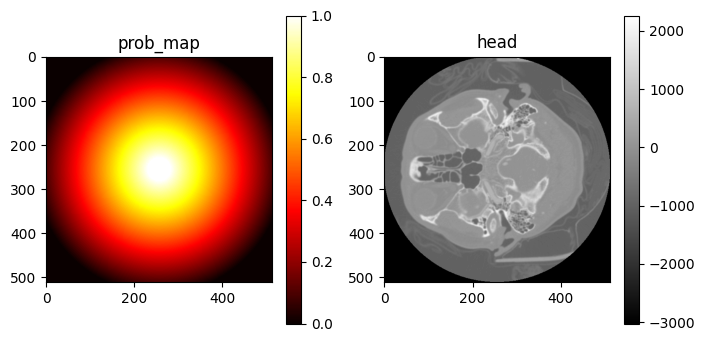

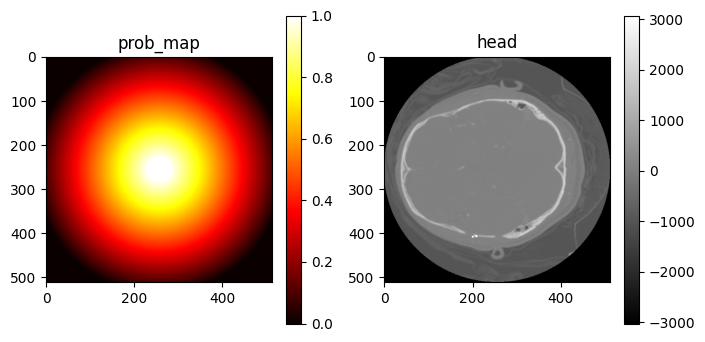

In [148]:
for i in range(40, 140, 50):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))    
    print_img(subject.prob_map.data[0], ax[0], title='prob_map', show_slice=i, cmap='hot')
    print_img(subject.head.data[0], ax[1], title='head', show_slice=i, cmap='gray')

In [149]:
torch.manual_seed(0)
max_queue_length = 25
patches_per_volume = 25
subjects = 1 * [subject]
transform = tio.Compose(
    (
        tio.CropOrPad(max_side),
        tio.RandomFlip(),
        tio.RandomAffine(degrees=360),
    )
)
dataset = tio.SubjectsDataset(subjects, transform=transform)
patch_size = (64, 64, 1)  # 2D slices

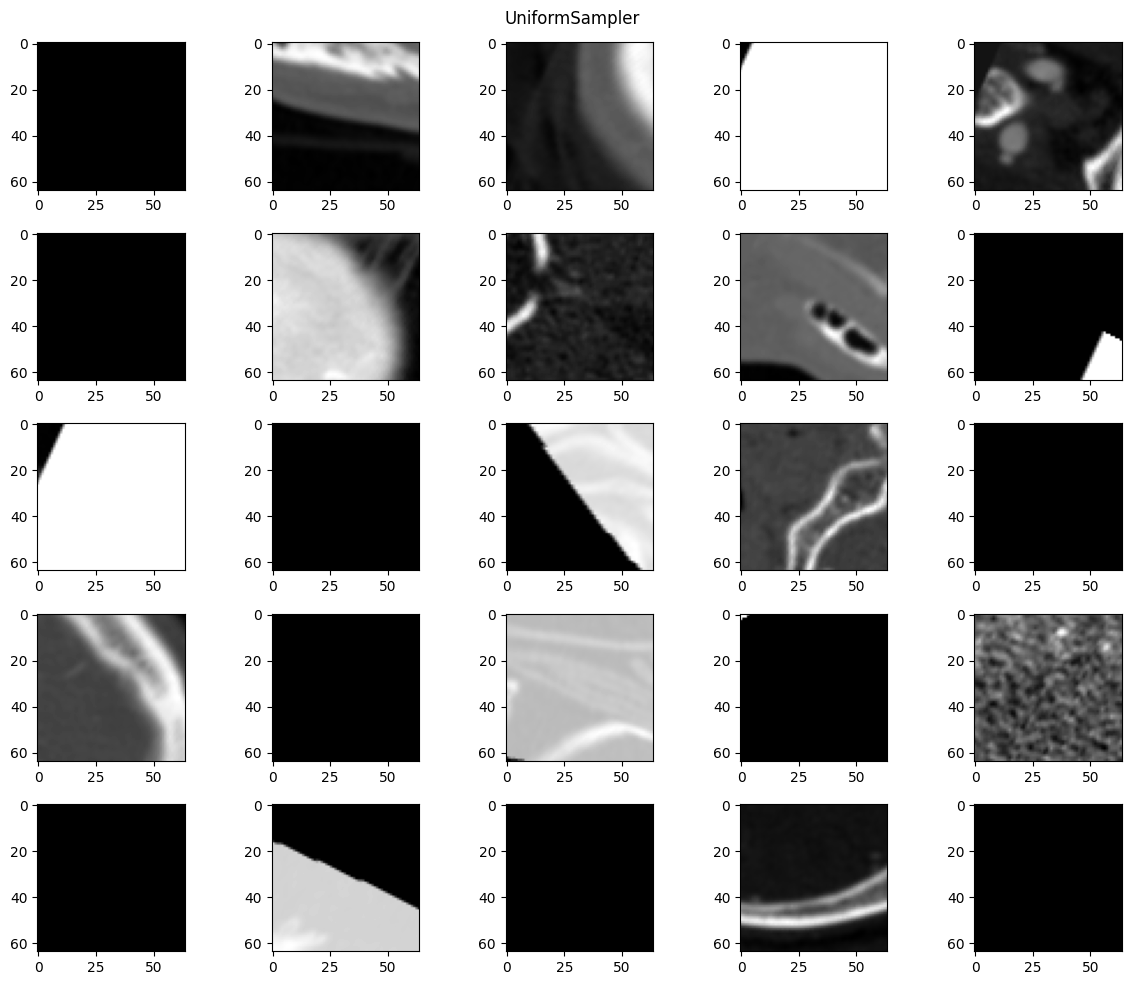

In [150]:
sampler = tio.UniformSampler(patch_size)
plot_batch(sampler)

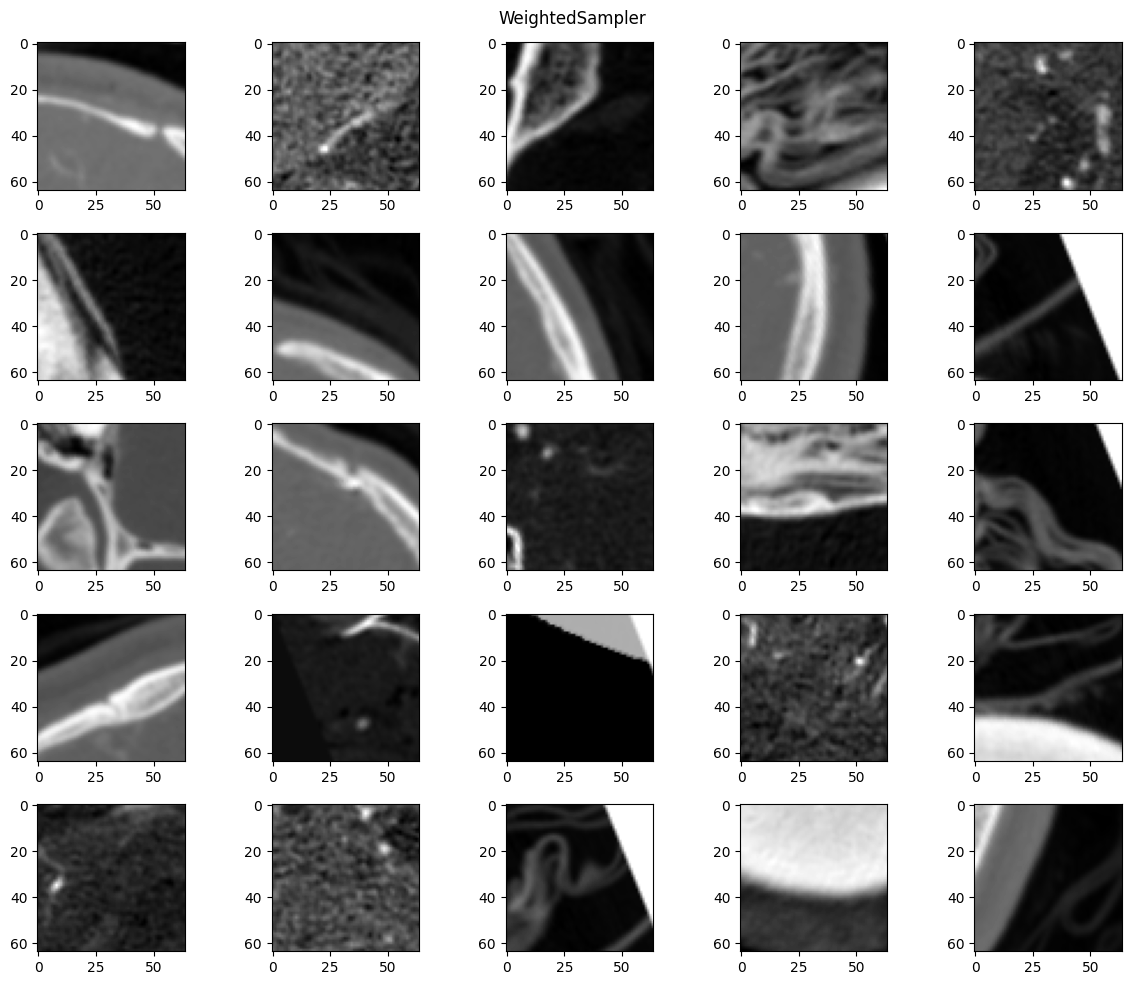

In [151]:
sampler = tio.WeightedSampler(patch_size, probability_map='prob_map')
plot_batch(sampler)
plt.show()